In [30]:
import os
import random
import requests
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText
import numpy as np
import spacy
import string
from wordcloud import WordCloud
import unicodedata
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
from collections import defaultdict

# Load FastText Model
#fasttext_model = FastText.load("fasttext_300dim_20epochs.model")

def load_filipino_context_words():
    """Load Filipino-related words from a file."""
    with open("filipino_context_words.txt", "r", encoding="utf-8") as file:
        return [line.strip() for line in file.readlines()]

#filipino_context_words = load_filipino_context_words()

# Folder paths
transcripts_folder_path = 'cleaned_transcripts/'
tags_folder_path = 'tags/'

# Function to load random documents
def load_random_documents(folder_path, sample_size=2086):
    all_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.txt')]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

    documents = []
    file_names = []
    for file_name in sampled_files:
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()
            if len(content.split()) >= 100:
                documents.append(content)
                file_names.append(file_name)
    return documents, file_names

documents, file_names = load_random_documents(transcripts_folder_path)

# Function to load video tags
def load_video_tags(folder_path):
    video_tags = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            video_id = file_name.split('_')[0]
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                tags_content = file.read().lower()
                video_tags[video_id] = tags_content.split()
    return video_tags

video_tags = load_video_tags(tags_folder_path)

# Fetch stopwords
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    return set(response.text.splitlines())

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 'news', 'netherlands', 'psy', 'subtitle', 'description', 'link', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya', 'successful', 'perfectly', 'yeap', 
    'wondering', 'fantastic', 'hurry', 'german', 'age', 'country', 'subscribing', 'bluesy', 'jump', 'pretty', 'understanding', 'personalized',
    'and', 'the', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'up', 'about', 'over', 'into', 'through', 'between', 'under', 'against', 'all',
    'you', 'haha', 'hahaha', 'ha', 'hey', 'bye', 'hello', 'hi', 'oh', 'blah', 'easy', 'alright', 'ta', 'day', 'ooh', 'en', 'do', 'lot', 'comment', 'notification', 
    'korean', 'jjajangmyeon', 'jajangmyeon', 'damn', 'yall', 'month', 'week', 'year', 'ohhh', 'pvf', 'dude', 'mmm', 'kagilagilalas', 'ofcourse', 'australia', 'uxo', 
    'atleast', 'yusuf', 'bangkok', 'ot', 'anytime', 'allover', 'kala', 'nope', 'wan', 'brazil', 'smooth', 'ot', 'timeshere', 'batchof', 'yep', 'opo', 'del',
    'gosh', 'po', 'ourself', 'wo', 'wait', 'ugh', 'nyc', 'whoa', 'nicaragua', 'yup', 'em', 'bout', 'le', 'omg', 'overwhelm', 'maam', 'nicer', 'haha', 'hahaha', 'ha', 
    'nbcs', 'lana', 'rc', 'whatsoever', 'oxy', 'decade', 'whyd', 'unknown', 'ahhhhh', 'ohoh', 'ohto', 'ohhhh', 'bruh', 'ooe', 'ahmedabad', 'mexico', 
    'understand', 'excuse', 'kinda', 'applause', 'oooh', 'thiswhat', 'nevermind', 'ahh', 'againthank', 'toto', 'aww', 'nah', 'bbmas', 'ay', 'op', 'huh', 'huhu',
    'tada', 'beacuse', 'voila', 'upstairs', 'thatswhy', 'yea', 'that', 'armenia', 'or', 'not', 'funwhat', 'aka', 'armeniathat', 'woosexy', 'worth', 'laugh', 'box', 
    'xd', 'vb', 'eff', 'ananya', 'welsh', 'latron', 'shout', 'whatwhat', 'what', 'pause', 'why', 'thats', 'byebye', 'iv', 'bye', 'ado', 'ownup', 'dom', 'jomm', 'sir', 
    'budgie', 'nomac', 'lavocha', 'germany', 'why', 'walang', 'superduper', 'philip', 'mom', 'jre', 'giddy', 'intro', 'dupe', 'europe', 'dream', 'team', 'dislike', 'content', 
    'yoongi', 'royale', 'ilu', 'jhope', 'day', 'jin', 'ecc', 'nyhs', 'nego', 'chavez', 'pb', 'everyones', 'epic', 'matter', 'oneonone', 'region', 'change', 'ho', 'seetoh', 
    'atin', 'vpn', 'facetune', 'busu', 'mackie', 'clyd', 'china', 'rest', 'friend', 'woah', 'dindins', 'poster', 'vibe', 'woman', 'boss', 'woah', 'type', 'mahana', 'joke', 
    'taller', 'insane', 'whang', 'psa', 'manatee', 'recommend', 'caesar', 'mmmhmm', 'mosul', 'dun', 'clue', 'naysayer', 'hindi', 'ko', 'pero', 'bulgaria', 'question', 'video', 
    'yobi', 'hindu', 'expat', 'option', 'gap', 'eu', 'simo', 'kouignamann', 'bct', 'month', 'cfo'
]
stop_words.update(custom_stop_words, kpop_keywords, broad_terms, more_keywords, github_stopwords)

lemmatizer = WordNetLemmatizer()

# Helper function to check if a word contains only Latin script characters
def is_latin_script(word):
    for char in word:
        if not ('LATIN' in unicodedata.name(char, '') or char.isdigit()):
            return False
    return True

def preprocess_text(doc, video_id, ngram_range=(1, 2), tag_weight=1, filipino_weight=2, ngram_weight_factor=1):
    """Preprocess text while considering Filipino context and video tags."""
    doc = doc.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(doc)
    tokens_with_pos = pos_tag(tokens)

    # Apply lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tokens_with_pos]

    # Generate n-grams
    ngram_tokens = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngram_tokens.extend([' '.join(gram) for gram in ngrams(lemmatized_tokens, n)])

    # Count n-gram frequency
    ngram_frequencies = Counter(ngram_tokens)

    # Filter stopwords and non-useful words
    filtered_tokens = []
    for word, pos in tokens_with_pos:
        if not word.isalpha() or word in stop_words:
            continue
        if pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']:
            continue  # Remove verbs and adjectives
        filtered_tokens.append(word)

    # Assign weight based on n-grams and Filipino similarity
    weighted_tokens = []
    for token in filtered_tokens:
        token_weight = 1 + ngram_frequencies.get(token, 0) * ngram_weight_factor
        weighted_tokens.extend([token] * int(token_weight))

    # Include video tags
    if video_id in video_tags:
        tags = video_tags[video_id]
        for tag in tags:
            if tag.isalpha():
                tag_weight_multiplier = tag_weight
                #filipino_similarity = get_filipino_similarity(tag)
                #if filipino_similarity > 0.3:
                    #tag_weight_multiplier *= filipino_weight * filipino_similarity
                weighted_tokens.extend([tag] * int(tag_weight_multiplier))

    return ' '.join(weighted_tokens)

def get_filipino_similarity(word):
    """Compute similarity to Filipino words using FastText."""
    if word in filipino_context_words:
        return 1
    try:
        similarities = [fasttext_model.wv.similarity(word, ref_word) for ref_word in filipino_context_words if ref_word in fasttext_model.wv]
        return max(similarities) if similarities else 0
    except KeyError:
        return 0
    
def get_wordnet_pos(treebank_tag):
    """Convert POS tag to WordNet format for lemmatization."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
# Load and preprocess all transcripts together
all_documents = []
video_ids = []
for file_name in os.listdir(transcripts_folder_path):
    if file_name.endswith('.txt'):
        video_id = file_name.split('_captions')[0]
        with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()
            if len(content.split()) >= 100:  # Minimum word count check
                processed_text = preprocess_text(content, video_id)
                all_documents.append(processed_text)
                video_ids.append(video_id)

# Create Dictionary and Corpus for LDA
dictionary = corpora.Dictionary([doc.split() for doc in all_documents])
corpus = [dictionary.doc2bow(doc.split()) for doc in all_documents]

# Train LDA on all transcripts
num_topics = 15  # Adjust based on coherence scoring if needed
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, eta='auto', alpha='auto', passes=50, random_state=42)

# Dictionary to store the number of videos per topic
topic_video_count = defaultdict(int)

# Associate videos with topics and update topic count
video_topic_mapping = {}
for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)

    # Extract topics with high probabilities
    assigned_topics = [topic for topic, prob in topic_distribution if prob > 0.2]  # Threshold can be tuned
    video_topic_mapping[video_id] = assigned_topics

    # Update the count for each assigned topic
    for topic in assigned_topics:
        topic_video_count[topic] += 1

# Print results
for video_id, topics in video_topic_mapping.items():
    print(f"Video {video_id} belongs to topics: {topics}")

# Print the number of videos per topic
print("\nNumber of videos per topic:")
for topic, count in sorted(topic_video_count.items()):
    print(f"Topic {topic}: {count} videos")

Video --8n6A8Q6M0 belongs to topics: [1]
Video -0FfyNZdHk0 belongs to topics: [0]
Video -4yu_13EHFM belongs to topics: [2, 14]
Video -6FvAU9H98w belongs to topics: [7]
Video -7vF5F-1btE belongs to topics: [0]
Video -9hDaG3nJwg belongs to topics: [10]
Video -Pe-c-CHkIo belongs to topics: [8, 9]
Video -U5-r29G-t0 belongs to topics: [0, 13]
Video 0-dAyU-yUWk belongs to topics: [14]
Video 008Fi25LbKY belongs to topics: [1, 7]
Video 00qBuhJeG-o belongs to topics: [0, 10]
Video 026urE67c8c belongs to topics: [0, 1]
Video 06Qq4to_l10 belongs to topics: [0, 9]
Video 09HUMZrCH3A belongs to topics: [6]
Video 0AuL6FQR3HE belongs to topics: [6]
Video 0ax6XooGykc belongs to topics: [0]
Video 0Cj35oMbb9Q belongs to topics: [1, 3]
Video 0E4c8VDmUTk belongs to topics: [0]
Video 0eTmLcoLe9s belongs to topics: [10]
Video 0f3m80ZA8BM belongs to topics: [10]
Video 0gc-NMhT8Y0 belongs to topics: [9]
Video 0ifwCzzCdvc belongs to topics: [7]
Video 0IJm5TFpldU belongs to topics: [0, 14]
Video 0IMWasj76yU belo

Topic 11: [('vendor', 0.16111776), ('puril', 0.1384203), ('magician', 0.08216912), ('mango', 0.04044029), ('chavacano', 0.039596923), ('piroshki', 0.023406342), ('meat', 0.022085678), ('recipe', 0.014813994), ('art', 0.012978482), ('trike', 0.012641235), ('mousse', 0.011175595), ('lumpia', 0.009742818), ('cabbage', 0.0092641665), ('cap', 0.009119545), ('dough', 0.00896865), ('baseball', 0.008884823), ('market', 0.0087091075), ('twist', 0.008264632), ('driver', 0.0061506983), ('hotel', 0.0060893735)]
Topic 4: [('god', 0.0787743), ('pension', 0.078367166), ('government', 0.06765819), ('lord', 0.050343778), ('programme', 0.035891194), ('slide', 0.027959889), ('jesus', 0.027844707), ('amen', 0.027621882), ('christ', 0.021199629), ('corporation', 0.021150615), ('bus', 0.020945892), ('money', 0.01700648), ('africa', 0.016668653), ('tax', 0.010755855), ('budget', 0.010581945), ('tunnel', 0.009508079), ('cost', 0.008987453), ('protection', 0.008463442), ('wheel', 0.008199994), ('nurse', 0.0077

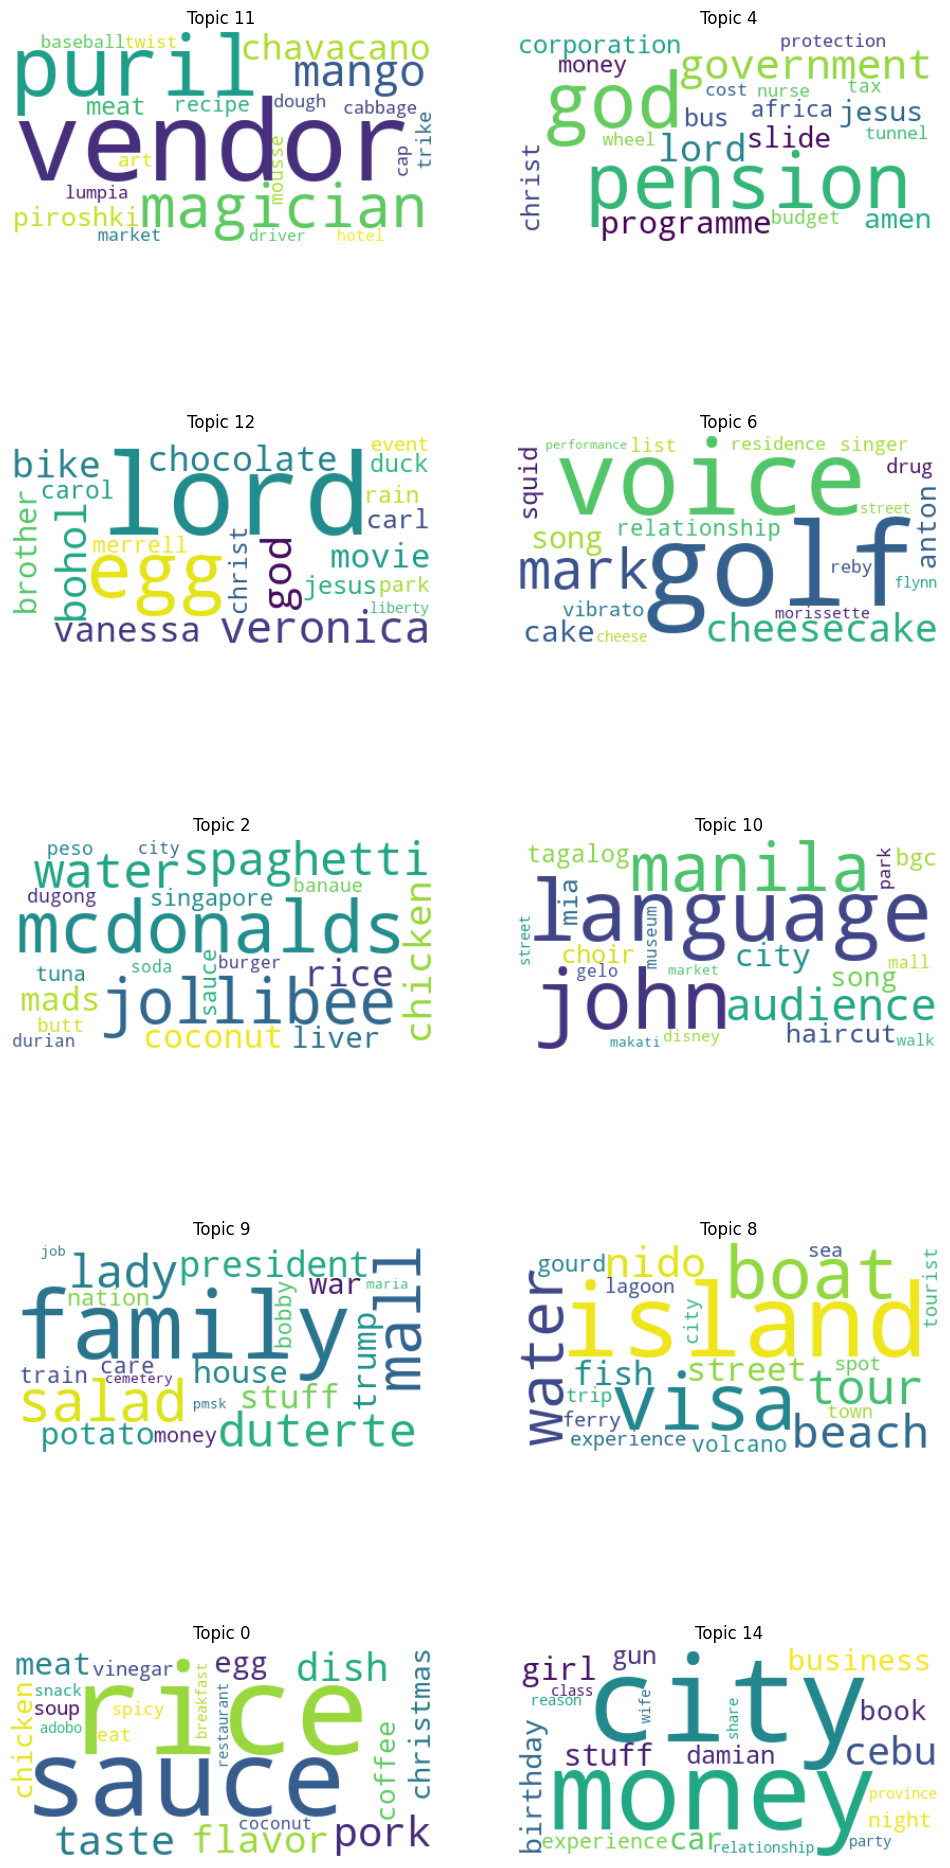

In [31]:
from gensim.models.coherencemodel import CoherenceModel
def display_wordclouds_grid(lda_model, num_words=50):
    """
    Displays WordClouds for each topic in a grid layout.
    Skips topics with no words to plot.
    
    Args:
        lda_model: Trained LDA model.
        num_words: Number of top words to consider for WordCloud.
    """
    num_words = int(num_words)  # Ensure num_words is an integer
    topics = lda_model.show_topics(num_words=num_words, formatted=False)
    
    # Filter out topics with no words
    valid_topics = [(t, words) for t, words in topics if words]

    if not valid_topics:
        print("No topics available to plot.")
        return  # Exit if no valid topics

    num_topics = len(valid_topics)
    num_cols = 2  # Two columns for side-by-side comparison
    num_rows = (num_topics + num_cols - 1) // num_cols  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    axes = axes.flatten()  # Flatten to easily iterate over

    for i, (t, words) in enumerate(valid_topics):
        # Generate word frequency dictionary for WordCloud
        word_freq = {word[0]: word[1] for word in words}
        wordcloud = WordCloud(width=400, height=200, background_color="white").generate_from_frequencies(word_freq)

        # Display the WordCloud
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].set_title(f"Topic {t}", fontsize=12)
        axes[i].axis("off")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove empty subplots

    plt.subplots_adjust(hspace=0.3, wspace=0.2)  # Adjust spacing between rows and columns
    plt.show()

# Function to display LDA evaluation metrics
def display_lda_evaluation_metrics(lda_model, corpus, dictionary):
    """
    Displays evaluation metrics for the LDA model.
    
    Args:
        lda_model: Trained LDA model.
        corpus: Gensim corpus.
        dictionary: Gensim dictionary.
        preprocessed_doc: Preprocessed document content.
    """
    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus)
    print(f"\nPerplexity: {perplexity}")
    
    # Calculate coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=[doc.split() for doc in all_documents], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score: {coherence_score}")

# Function to display filtered/non-filtered topic-word distributions
def display_topic_word_distributions(lda_model, num_words=20):
    """
    Displays topic-word distributions before and after filtering repeated words.
    
    Args:
        lda_model: Trained LDA model.
        num_words: Number of top words to display per topic.
    """
    # Get non-filtered topics
    non_filtered_topics = lda_model.show_topics(num_words=num_words, formatted=False)
    
    for t, words in non_filtered_topics:
        print(f"Topic {t}: {words}")

display_topic_word_distributions(lda_model)
display_lda_evaluation_metrics(lda_model, corpus, dictionary)
display_wordclouds_grid(lda_model, num_words=20)